# Linguistics 110: Vowel Formants

### Professor Susan Lin

_short description of the notebook?_

## Table of Contents

1 - [Exploring TIMIT Data](#timit)

2 - [Using the Class's Data](#cls)

3 - [Formants vs Height](#fvh)

4 - [Vowel Spaces](#vs)

5 - [Not sure what to call this section](#not sure)

Remember that to run a cell, you can either click the play button in the toolbar, or you can press `shift` and `enter` on your keyboard. To get a quick review of Jupyter notebooks, you can look at the [VOT Notebook](http://datahub.berkeley.edu/user-redirect/interact?account=ds-modules&repo=LINGUIS-110&branch=master&path=VOT). __Make sure to run the following cell before you get started.__

In [1]:
# DON'T FORGET TO RUN THIS CELL
import math
import numpy as np
import pandas as pd
import seaborn as sns
import datascience as ds
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Exploring TIMIT Data <a id='timit'></a>

We will start off by exploring [TIMIT](https://en.wikipedia.org/wiki/TIMIT) data taken from 8 different regions. These measurements are taken at the midpoint of vowels, where vowel boundaries were determined automatically using forced alignment.

### Uploading the data

Prior to being able to work with the data, we have to upload our dataset. The following two lines of code will read in our data and create a dataframe. The last line of code prints the `timit` dataframe, but instead of printing the whole dataframe, by using the method `.head`, it only prints the first 5 rows.

In [2]:
timit = pd.read_csv('data/timitvowels.csv')
timit.head()

,speaker,gender,region,height,word,vowel,duration,F1,F2,F3,f0
0,cjf0,female,1,162.56,SHE,IY,0.08,486.2,2467.9,3185.1,244.9
1,cjf0,female,1,162.56,HAD,AE,0.10,595.1,2067.0,2976.7,241.6
2,cjf0,female,1,162.56,YOUR,UH,0.04,468.7,1956.1,3061.4,201.9
3,cjf0,female,1,162.56,DARK,AA,0.10,740.4,1674.1,2767.3,221.5
4,cjf0,female,1,162.56,SUIT,UW,0.17,464.0,1698.0,2904.9,232.6


Look at the dataframe you created and try to figure out what each column measures. Each column represents a different attribute, see the following table for more information.

|Column Name|Details|
|---|---|
|speaker|unique speaker ID|
|gender|Speaker’s self-reported gender|
|region|Speaker dialect region number|
|word|Lexical item (from sentence prompt)|
|vowel|Vowel ID|
|duration|Vowel duration (seconds)|
|F1/F2/F3/f0|f0 and F1-F3 in BPM (Hz)|

Sometimes data is encoded with with an identifier, or key, to save space and simplify calculations. Each of those keys corresponds to a specific value. If you look at the `region` column, you will notice that all of the values are numbers. Each of those numbers corresponds to a region, for example, in our first row the speaker, `cjf0`, is from region `1`. That corresponds to New England. Below is a table with all of the keys for `region`.

|Key|Region|
|---|---|
|1|New England|
|2|Northern|
|3|North Midland|
|4|South Midland|
|5|Southern|
|6|New York City|
|7|Western|
|8|Army Brat|

### Transformations

When inspecting data, you may realize that there are changes to be made -- possibly due to the representation to the data or errors in the recording. Before jumping into analysis, it is important to clean the data. 

One thing to notice about `timit` is that the column `vowel` contains ARPABET identifiers for the vowels. We want to convert the vowel column to be IPA characters, and will do so in the cell below.

In [3]:
IPAdict = {"AO" : "ɔ", "AA" : "ɑ", "IY" : "i", "UW" : "u", "EH" : "ɛ", "IH" : "ɪ", "UH":"ʊ", "AH": "ʌ", "AX" : "ə", "AE":"æ", "EY" :"eɪ", "AY": "aɪ", "OW":"oʊ", "AW":"aʊ", "OY" :"ɔɪ", "ER":"ɚ"}
timit['vowel'] = [IPAdict[x] for x in timit['vowel']]
timit.head()

,speaker,gender,region,height,word,vowel,duration,F1,F2,F3,f0
0,cjf0,female,1,162.56,SHE,i,0.08,486.2,2467.9,3185.1,244.9
1,cjf0,female,1,162.56,HAD,æ,0.10,595.1,2067.0,2976.7,241.6
2,cjf0,female,1,162.56,YOUR,ʊ,0.04,468.7,1956.1,3061.4,201.9
3,cjf0,female,1,162.56,DARK,ɑ,0.10,740.4,1674.1,2767.3,221.5
4,cjf0,female,1,162.56,SUIT,u,0.17,464.0,1698.0,2904.9,232.6


Most of the speakers will say the same vowel multiple times, so we are going to average those values together. The end result will be a dataframe where each row represents the average values for each vowel for each speaker.

In [4]:
timit_avg = timit.groupby(['speaker', 'vowel', 'gender', 'region']).mean().reset_index()
timit_avg.head()

,speaker,vowel,gender,region,height,duration,F1,F2,F3,f0
0,/1/2000,eɪ,male,2,175.26,0.105000,447.20,1947.233333,2547.466667,138.366667
1,/1/2000,i,male,2,175.26,0.063333,374.00,1995.966667,2529.666667,137.266667
2,/1/2000,oʊ,male,2,175.26,0.080000,498.75,1242.300000,2523.050000,142.100000
3,/1/2000,u,male,2,175.26,0.060000,407.85,1157.050000,2353.200000,148.150000
4,/1/2000,æ,male,2,175.26,0.098000,690.98,1715.980000,2548.220000,145.100000


### Splitting on Gender

Using the same dataframe from above, `timit_avg`, we are going to split into dataframes grouped by gender. To identify the possible values of gender in the `gender` column, we can use the method `.unique` on the column.

In [5]:
timit_avg.gender.unique()

array(['male', 'female'], dtype=object)

You could see that for this specific dataset there are only "female" and "male" values in the column. Given that information, we'll create two subsets based off of gender. 

We'll split `timit_avg` into two separate dataframes, one for females, `timit_female`, and one for males, `timit_male`. Creating these subset dataframes does not affect the original `timit_avg` dataframe.

In [6]:
timit_female = timit_avg[timit_avg['gender'] == 'female']
timit_male = timit_avg[timit_avg['gender'] == 'male']

### Distribution of Formants

We want to inspect the distributions of F1, F2, and F3 for those that self-report as male and those that self-report as female to identify possible trends or relationships. Having our two split dataframes, `timit_female` and `timit_male`, eases the plotting process. 

Run the cell below to see the distribution of `F1`.

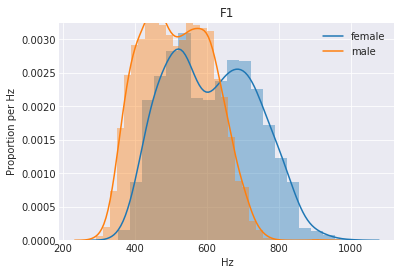

In [7]:
sns.distplot(timit_female['F1'], kde_kws={"label": "female"})
sns.distplot(timit_male['F1'], kde_kws={"label": "male"})
plt.title('F1')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

Does there seem to be a notable difference between male and female distributions of F1?

Next, we plot F2.

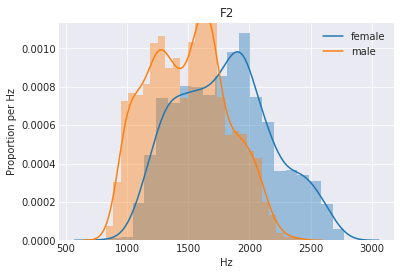

In [8]:
sns.distplot(timit_female['F2'], kde_kws={"label": "female"})
sns.distplot(timit_male['F2'], kde_kws={"label": "male"})
plt.title('F2')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

Finally, we create the same visualization, but for F3.

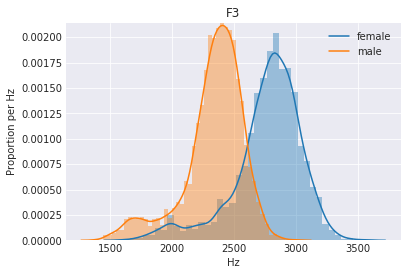

In [9]:
sns.distplot(timit_female['F3'], kde_kws={"label": "female"})
sns.distplot(timit_male['F3'], kde_kws={"label": "male"})
plt.title('F3')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

Do you see a more pronounced difference across the the different F values? Are they the same throughout? Can we make any meaningful assumptions from these visualizations?

An additional question: How do you think the fact that we average each vowel together first for each individual affects the shape of the histograms?

## Using the Class's Data <a id='cls'></a>

This portion of the notebook will rely on the data that was submit for HW5. Just like we did for the TIMIT data, we are going to read it into a dataframe and modify the column `vowel` to reflect the corresponding IPA translation. We will name the dataframe `class_data`.

In [10]:
# reading in the data
class_data = pd.read_csv('data/110_formants.csv')
class_data.head()

,ID,Language,Gender,Height,vowel,F1,F2,F3
1,1,English,Female,168.0,AA,948,1099,2939
2,1,English,Female,168.0,AE,931,1922,2897
3,1,English,Female,168.0,AH,733,1348,2523
4,1,English,Female,168.0,EH,693,2004,2873
5,1,English,Female,168.0,ER,608,1784,1885


The `ID` column contains a unique value for each individual. Each individual has a row for each of the different vowels they measured.

In [11]:
# translating the vowel column
class_data['vowel'] = [IPAdict[x] for x in class_data['vowel']]
class_data.head()

,ID,Language,Gender,Height,vowel,F1,F2,F3
1,1,English,Female,168.0,ɑ,948,1099,2939
2,1,English,Female,168.0,æ,931,1922,2897
3,1,English,Female,168.0,ʌ,733,1348,2523
4,1,English,Female,168.0,ɛ,693,2004,2873
5,1,English,Female,168.0,ɚ,608,1784,1885


### Splitting on Gender

As we did with the TIMIT data, we are going to split `class_data` based on self-reported gender. We need to figure out what the possible responses for the column were.

In [12]:
class_data['Gender'].unique()

array(['Female', 'Male', 'Prefer not to answer'], dtype=object)

Notice that there are three possible values for the column. We do not have a large enough sample size to responsibly come to conclusions for `Prefer not to answer`, so for now we'll compare `Male` and `Female`. We'll call our new split dataframes `class_female` and `class_male`.

In [13]:
class_female = class_data[class_data['Gender'] == 'Female']
class_male = class_data[class_data['Gender'] == 'Male']

### Comparing Distributions

The following visualizations compare the the distribution of formants for males and females, like we did for the TIMIT data.

First, we'll start with `F1`.

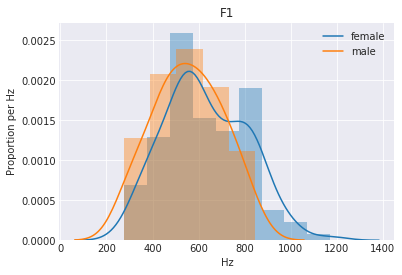

In [14]:
sns.distplot(class_female['F1'], kde_kws={"label": "female"})
sns.distplot(class_male['F1'], kde_kws={"label": "male"})
plt.title('F1')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

Next is `F2`.

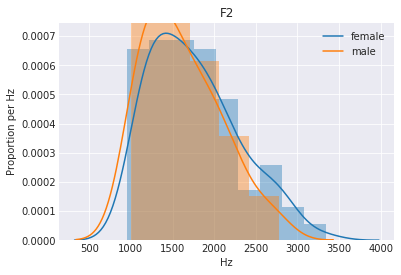

In [15]:
sns.distplot(class_female['F2'], kde_kws={"label": "female"})
sns.distplot(class_male['F2'], kde_kws={"label": "male"})
plt.title('F2')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

And finally `F3`.

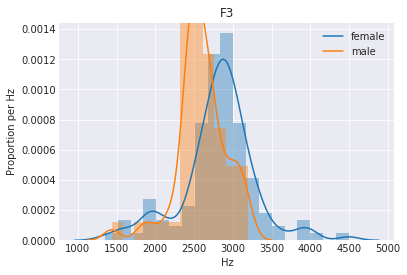

In [16]:
sns.distplot(class_female['F3'], kde_kws={"label": "female"})
sns.distplot(class_male['F3'], kde_kws={"label": "male"})
plt.title('F3')
plt.xlabel("Hz")
plt.ylabel('Proportion per Hz');

Do the spread of values appear to be the same for females and males? Do the same patterns that occur in the TIMIT data appear in the class's data?

## Formants vs Height <a id='fvh'></a>

We are going to compare each of the formants and height to see if there is a relationship between the two. To help visualize that, we are going to plot a regression line, which is also referred to as the line of best fit.

We are going to use the _maximum_ of each formant to compare to height. So for each speaker, we will calculate their greatest `F1`, `F2`, and `F3` across all vowels, then compare one of those to their height. We create the necessary dataframe in the cell below using the class's data.

In [17]:
genders = class_data['Gender']
plotting_data = class_data.drop('vowel', axis=1)[np.logical_or(genders == 'Male', genders == 'Female')]
maxes = plotting_data.groupby(['ID', 'Gender']).max().reset_index()
maxes.columns = ['ID', 'Gender', 'Language', 'Height', 'Max F1', 'Max F2', 'Max F3']
maxes_female = maxes[maxes['Gender'] == 'Female']
maxes_male = maxes[maxes['Gender'] == 'Male']
maxes.head()

,ID,Gender,Language,Height,Max F1,Max F2,Max F3
0,1,Female,English,168.00,948,2879,3385
1,2,Female,Mandarin,163.00,881,3080,3550
2,3,Male,English,173.00,682,2256,2904
3,4,Female,English,154.94,836,2788,4497
4,5,Female,English,156.00,1011,3343,4002


First we will plot `Max F1` against `Height`.

_Note: Each gender has a different color dot, but the line represents the line of best fit for ALL points._

female: green
male: orange


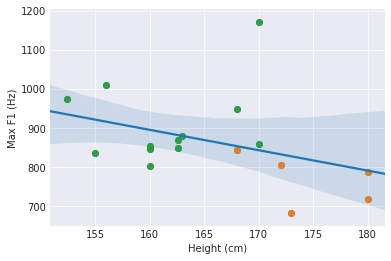

In [18]:
sns.regplot('Height', 'Max F1', data=maxes)
sns.regplot('Height', 'Max F1', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F1', data=maxes_female, fit_reg=False)
plt.xlabel('Height (cm)')
plt.ylabel('Max F1 (Hz)')
print('female: green')
print('male: orange')

Is there a general trend for the data that you notice? What do you notice about the different color dots?

Next, we plot `Max F2` on `Height`.

female: green
male: orange


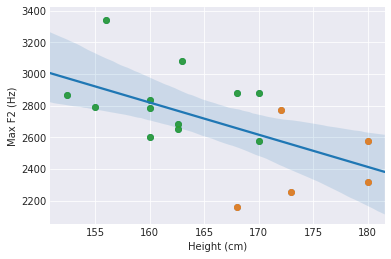

In [19]:
sns.regplot('Height', 'Max F2', data=maxes)
sns.regplot('Height', 'Max F2', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F2', data=maxes_female, fit_reg=False)
plt.xlabel('Height (cm)')
plt.ylabel('Max F2 (Hz)')
print('female: green')
print('male: orange')

Finally, `Max F3` vs `Height`.

female: green
male: orange


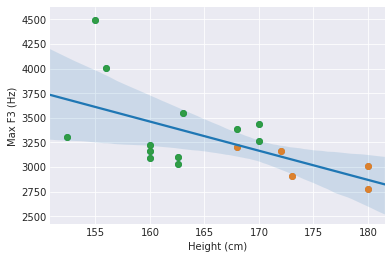

In [20]:
sns.regplot('Height', 'Max F3', data=maxes)
sns.regplot('Height', 'Max F3', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F3', data=maxes_female, fit_reg=False)
plt.xlabel('Height (cm)')
plt.ylabel('Max F3 (Hz)')
print('female: green')
print('male: orange')

Do you notice a difference between the trends for the three formants?

Now we are going to plot two lines of best fit -- one for males, one for females. Before we plotted one line for all of the values, but now we are separating by gender to see if gender explains some of the difference in formants values. 

For now, we're going deal with just `Max F1`.

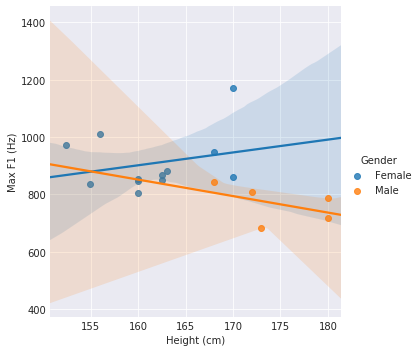

In [21]:
sns.lmplot('Height', 'Max F1', data=maxes, hue='Gender')
plt.xlabel('Height (cm)')
plt.ylabel('Max F1 (Hz)');

Is there a noticeable difference between the two? Did you expect this result?

We're going to repeat the above graph, plotting a different regression line for males and females, but this time, using `timit` -- having a larger sample size may help expose patterns. Before we do that, we have to repeat the process of calulating the maximum value for each formants for each speaker. Run the cell below to do that and generate the plot.

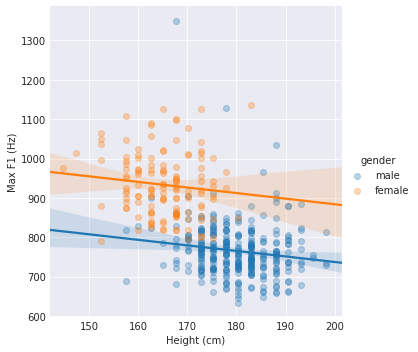

In [22]:
timit_maxes = timit.groupby(['speaker', 'gender']).max().reset_index()
timit_maxes.columns = ['speaker', 'gender', 'region', 'height', 'word', 'vowel', 'Max duration', 'Max F1', 'Max F2', 'Max F3', 'Max f0']
sns.lmplot('height', 'Max F1', data=timit_maxes, hue='gender', scatter_kws={'alpha':0.3})
plt.xlabel('Height (cm)')
plt.ylabel('Max F1 (Hz)');

Does this graph differ from the one based on `class_data`? If it does, what are some possible explanations for this? From the visualization, what can you say about height as a predictor of `Max F1`? Do you think gender plays a role in the value of `Max F1`?

Do you think similar patterns would emerge for `Max F2` and `Max F3`? We only used `Max F1`, but consider trying to plot them by copying some of the code from above and making slight alterations (remember that to insert a code cell below, you can either press `esc + b` or click `Insert > Insert Cell Below` on the toolbar).

## Vowel Diagrams <a id='vs'></a>

Run the cell below to define some functions that we will be using.

In [23]:
def plot_blank_vowel_chart():
    im = plt.imread('images/blankvowel.png')
    plt.imshow(im, extent=(plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]))

def plot_vowel_space(avgs_df):
    plt.figure(figsize=(10, 8))
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    for i in range(len(avgs_df)):
        plt.scatter(avgs_df['F2'][i], avgs_df['F1'][i], marker=r"$ {} $".format(avgs_df.index[i]), s=1000)
        
    plt.ylabel('F1')
    plt.xlabel('F2')

We are going to be recreating the following graphic.

![](images/notblank.png)

Before we can get to creating, we need to get a singular value for each column for each of the vowels (so we can create coordinate pairs). To do this, we are going to find the average formant values for each of the vowels in our dataframes. We'll do this for both `timit` and `class_data`.

In [24]:
class_vowel_avgs = class_data.groupby('vowel').mean()
class_vowel_avgs.head()

,ID,Height,F1,F2,F3
vowel,,,,,
eɪ,9.5,165.192222,508.777778,2344.666667,2947.388889
i,9.5,165.192222,356.500000,2711.222222,3211.444444
oʊ,9.5,165.192222,604.111111,1289.000000,2787.333333
u,9.5,165.192222,406.500000,1445.222222,2731.833333
æ,9.5,165.192222,849.277778,1840.222222,2737.166667


In [25]:
timit_vowel_avgs = timit.groupby('vowel').mean()
timit_vowel_avgs.head()

,region,height,duration,F1,F2,F3,f0
vowel,,,,,,,
eɪ,4.322006,175.547107,0.115782,492.412244,2043.718393,2632.371197,142.937756
i,4.266060,175.638252,0.096248,410.808897,2143.726578,2693.280529,153.532916
oʊ,4.226876,175.856863,0.122723,559.736591,1152.477836,2563.795288,150.992205
u,4.209927,175.879342,0.096630,418.927231,1561.519126,2464.922996,148.428415
æ,4.226215,175.410696,0.117523,650.748285,1763.569110,2542.692548,140.606737


Each of these new tables has a row for each vowel, which comprisises of the averaged values across all speakers.

### Plotting the Vowel Space

Run the cell below to construct a vowel space for the class's data, in which we plot `F1` on `F2`.

_Note that both axes are descending._

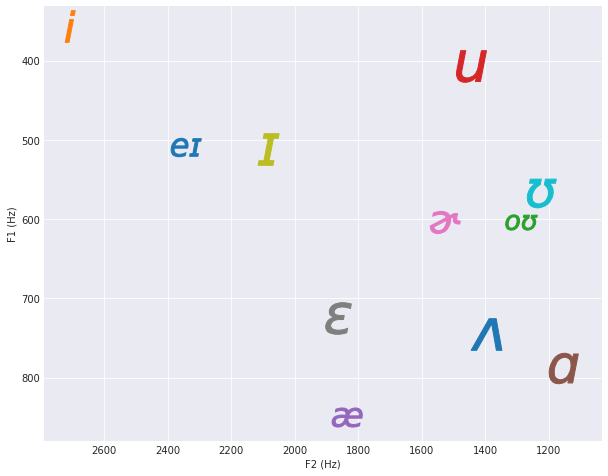

In [26]:
plot_vowel_space(class_vowel_avgs)
plt.xlabel('F2 (Hz)')
plt.ylabel('F1 (Hz)');

### Using Logarithmic Axes

In our visualization above, we use linear axes in order to construct our vowel space. The chart we are trying to recreate has logged axes (though the picture does not indicate it). Below we log-transform all of the values in our dataframes.

In [27]:
log_timit_vowels = timit_vowel_avgs.apply(np.log)
log_class_vowels = class_vowel_avgs.apply(np.log)
log_class_vowels.head()

,ID,Height,F1,F2,F3
vowel,,,,,
eɪ,2.251292,5.10711,6.232011,7.759899,7.988675
i,2.251292,5.10711,5.876334,7.905155,8.074476
oʊ,2.251292,5.10711,6.403758,7.161622,7.932841
u,2.251292,5.10711,6.007584,7.276018,7.912728
æ,2.251292,5.10711,6.744386,7.517642,7.914679


Below we plot the vowel space using these new values.

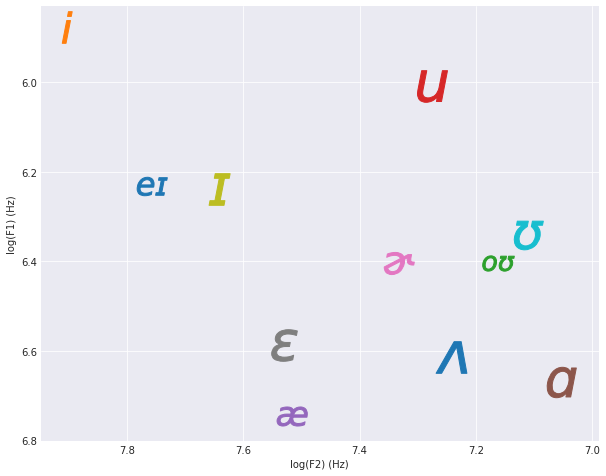

In [28]:
plot_vowel_space(log_class_vowels)
plt.xlabel('log(F2) (Hz)')
plt.ylabel('log(F1) (Hz)');

What effect does using the logged values have, if any? What advantages does using these values have? Are there any negatives? [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/) might give some ideas.

### Overlaying a Vowel Space Chart

Finally, we are going to overlay a blank vowel space chart outline to see how close our data reflects the theoretical vowel chart.

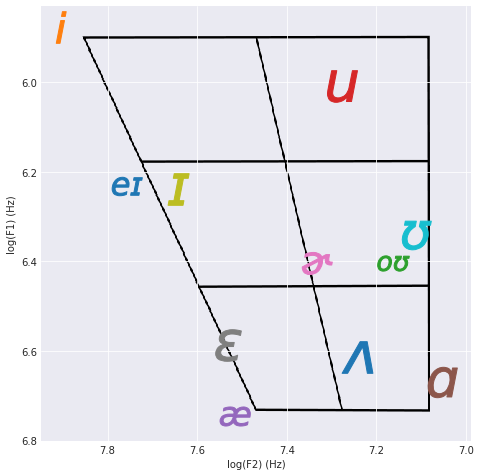

In [29]:
plot_vowel_space(log_class_vowels)
plot_blank_vowel_chart()
plt.xlabel('log(F2) (Hz)')
plt.ylabel('log(F1) (Hz)');

How well does it match the original?

Below we generate the same graph, except using the information from the TIMIT dataset.

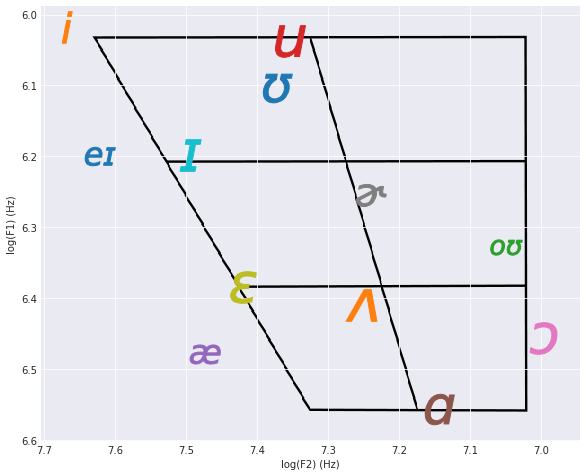

In [30]:
plot_vowel_space(log_timit_vowels)
plot_blank_vowel_chart()
plt.xlabel('log(F2) (Hz)')
plt.ylabel('log(F1) (Hz)');

How does the TIMIT vowel space compare to the vowel space from our class data? What may be the cause for any differences between our vowel space and the one constructed using the TIMIT data? Do you notice any outliers or do any points that seem off?

## Not sure what to call this section <a id='not sure'></a>

Possibly include link to paper Susan mentioned :)

timit data below

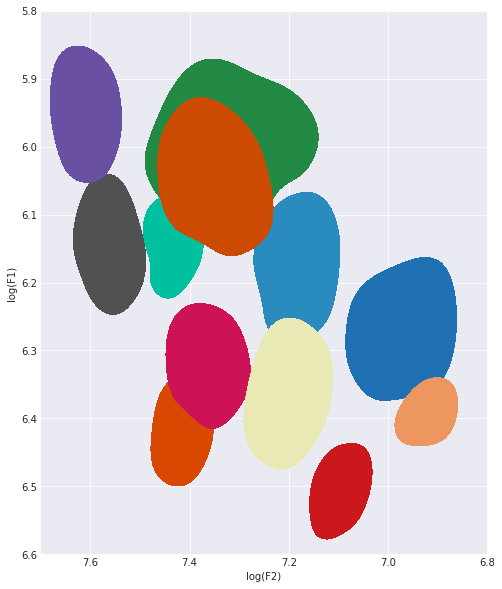

In [31]:
plt.figure(figsize=(8, 10))
pick_vowel = lambda v: timit_avg[timit_avg['vowel'] == v]
colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', \
          'Reds', 'GnBu', 'PuRd', 'winter', 'YlOrBr', 'pink', 'copper']

for vowel, color in list(zip(timit_avg.vowel.unique(), colors)):
    vowel_subset = pick_vowel(vowel)
    sns.kdeplot(vowel_subset['F2'].apply(np.log), vowel_subset['F1'].apply(np.log), n_levels=1, cmap=color, shade=True, shade_lowest=False)
    
plt.xlim(7.7, 6.8)
plt.ylim(6.6, 5.8)
plt.xlabel('log(F2)')
plt.ylabel('log(F1)')

class data below

needed to expand the axes to capture the class data

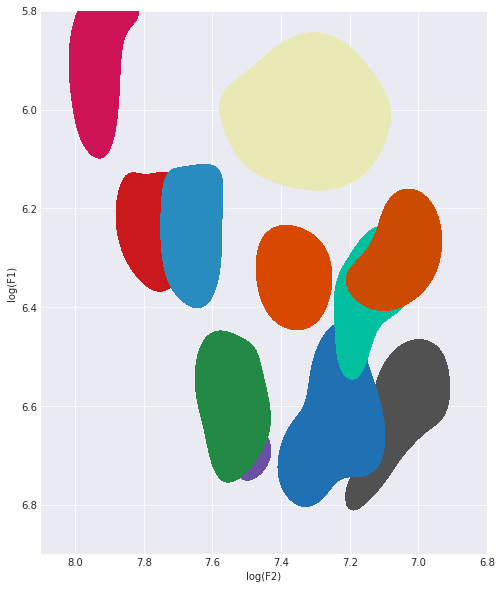

In [32]:
plt.figure(figsize=(8, 10))
pick_vowel = lambda v: class_data[class_data['vowel'] == v]
colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', \
          'Reds', 'GnBu', 'PuRd', 'winter', 'YlOrBr', 'pink', 'copper']

for vowel, color in list(zip(class_data.vowel.unique(), colors)):
    vowel_subset = pick_vowel(vowel)
    sns.kdeplot(vowel_subset['F2'].apply(np.log), vowel_subset['F1'].apply(np.log), n_levels=1, cmap=color, shade=True, shade_lowest=False)
    
plt.xlim(8.1, 6.8)
plt.ylim(6.9, 5.8)
plt.xlabel('log(F2)')
plt.ylabel('log(F1)')